In [42]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


In [43]:
# Load your last 100 games
with open("last_100_chess_games.json", "r") as file:
    games = json.load(file)


In [44]:
from google.colab import files
uploaded = files.upload()

Saving last_100_chess_games.json to last_100_chess_games (4).json


## Hypothesis

**H₀ (Null Hypothesis):** Rating difference has no effect on win rate.  
**H₁ (Alternative Hypothesis):** A greater rating difference (in my favor) increases my win rate.


In [45]:
with open("last_100_chess_games.json", "r") as file:
    games = json.load(file)

In [46]:
# Extract relevant data
extracted_data = []
for game in games:
    color = "White" if game["white"]["username"].lower() == "samuraibartu" else "Black"
    result = game["white"]["result"] if color == "White" else game["black"]["result"]
    my_rating = game["white"]["rating"] if color == "White" else game["black"]["rating"]
    opponent_rating = game["black"]["rating"] if color == "White" else game["white"]["rating"]

    extracted_data.append({
        "Date": pd.to_datetime(game["end_time"], unit='s'),
        "Time Control": game.get("time_control"),
        "Time Class": game.get("time_class"),
        "Result": result,
        "My Color": color,
        "My Rating": my_rating,
        "Opponent Rating": opponent_rating,
        "Opponent Username": game["black"]["username"] if color == "White" else game["white"]["username"],
        "URL": game.get("url")
    })

df = pd.DataFrame(extracted_data)
df["Rating Diff"] = df["My Rating"] - df["Opponent Rating"]
df["Win"] = df["Result"].apply(lambda x: 1 if x.lower() == "win" else 0)


df.head()


,Date,Time Control,Time Class,Result,My Color,My Rating,Opponent Rating,Opponent Username,URL,Rating Diff,Win
0,2025-04-09 12:40:16,180+2,blitz,resigned,Black,1458,1445,JensJensen_3636,https://www.chess.com/game/live/137192779550,13,0
1,2025-04-09 12:47:27,180+2,blitz,win,Black,1465,1409,romualdocruz,https://www.chess.com/game/live/137192880606,56,1
2,2025-04-09 12:54:44,180+2,blitz,resigned,White,1456,1418,romualdocruz,https://www.chess.com/game/live/137193097752,38,0
3,2025-04-09 12:56:35,180+2,blitz,win,Black,1464,1457,JoelEdisan1970,https://www.chess.com/game/live/137193321262,7,1
4,2025-04-09 13:02:40,180+2,blitz,win,Black,1472,1471,feodor92,https://www.chess.com/game/live/137193378240,1,1


In [47]:
# Opponent Strength kategorisini oluştur
def classify_strength(diff):
    if diff > 100:
        return "Much Weaker"
    elif diff > 20:
        return "Weaker"
    elif diff > -20:
        return "Equal"
    elif diff > -100:
        return "Stronger"
    else:
        return "Much Stronger"

df["Opponent Strength"] = df["Rating Diff"].apply(classify_strength)

# Encoding işlemleri
from sklearn.preprocessing import LabelEncoder
df["My Color Encoded"] = LabelEncoder().fit_transform(df["My Color"])
df["Strength Encoded"] = LabelEncoder().fit_transform(df["Opponent Strength"])

# ML veri setini hazırla
X = df[["My Rating", "Opponent Rating", "Rating Diff", "My Color Encoded", "Strength Encoded"]]
y = df["Win"]

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6
[[6 3]
 [5 6]]
              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.67      0.55      0.60        11

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



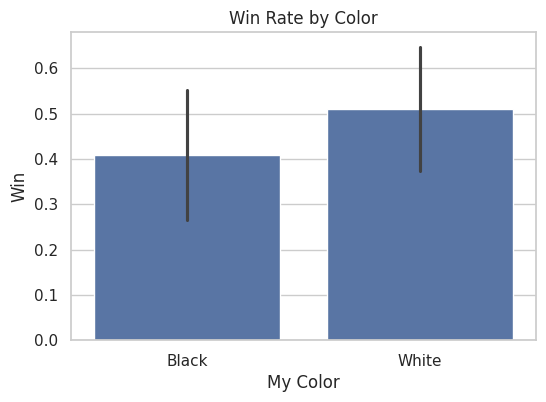

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x="My Color", y="Win")
plt.title("Win Rate by Color")
plt.show()


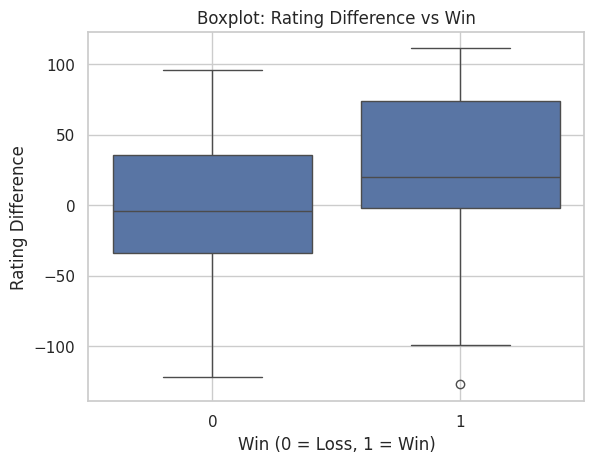

In [49]:
sns.boxplot(x="Win", y="Rating Diff", data=df)
plt.title("Boxplot: Rating Difference vs Win")
plt.xlabel("Win (0 = Loss, 1 = Win)")
plt.ylabel("Rating Difference")
plt.grid(True)
plt.show()


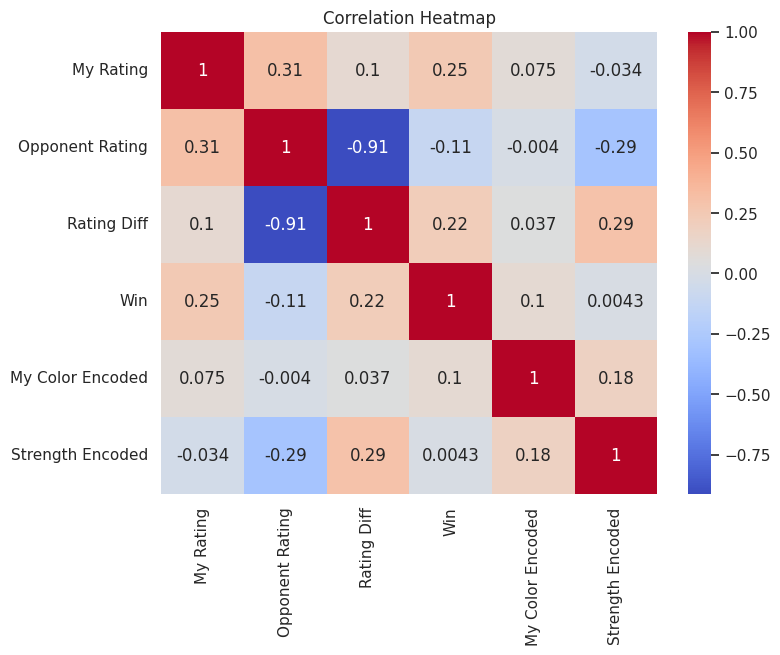

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


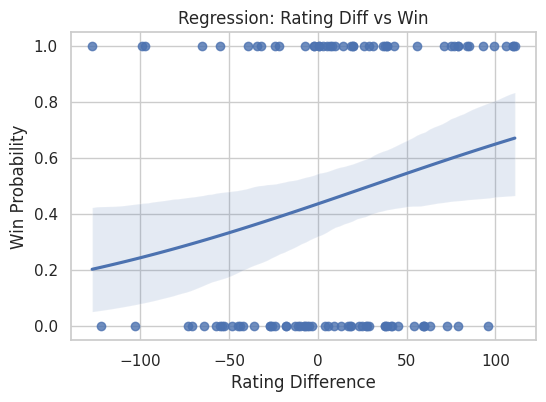

In [51]:
plt.figure(figsize=(6, 4))
sns.regplot(x="Rating Diff", y="Win", data=df, logistic=True)
plt.title("Regression: Rating Diff vs Win")
plt.xlabel("Rating Difference")
plt.ylabel("Win Probability")
plt.grid(True)
plt.show()


In [52]:
from scipy.stats import ttest_ind

# Win == 1 olanlar ve Win == 0 olanlar
win_group = df[df["Win"] == 1]["Rating Diff"]
loss_group = df[df["Win"] == 0]["Rating Diff"]

# t-testi
t_stat, p_val = ttest_ind(win_group, loss_group)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}")

if p_val < 0.05:
    print("❗Reject H₀: Rating difference has a significant effect on win rate.")
else:
    print("✅ Fail to Reject H₀: No significant effect found.")


T-statistic: 2.230
P-value: 0.02800
❗Reject H₀: Rating difference has a significant effect on win rate.


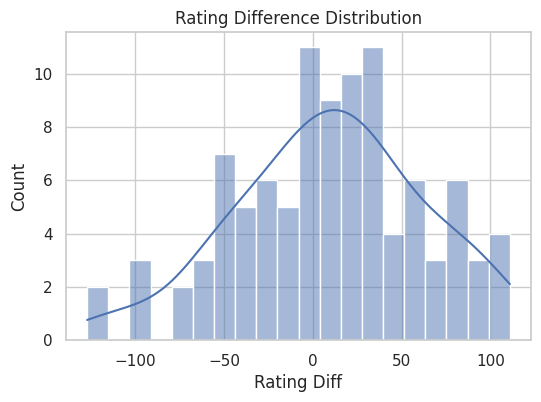

In [53]:
plt.figure(figsize=(6, 4))
sns.histplot(df["Rating Diff"], bins=20, kde=True)
plt.title("Rating Difference Distribution")
plt.show()


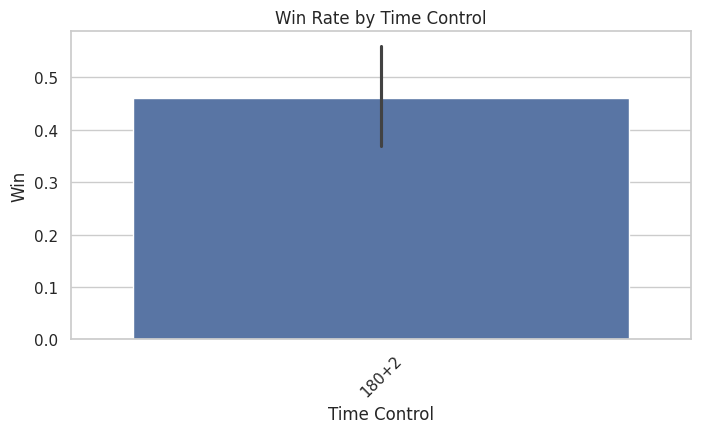

In [54]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x="Time Control", y="Win")
plt.title("Win Rate by Time Control")
plt.xticks(rotation=45)
plt.show()


In [55]:
greater = df[df["Rating Diff"] > 0]["Win"]
less_equal = df[df["Rating Diff"] <= 0]["Win"]
t_stat, p_val = ttest_ind(greater, less_equal)

print("T-statistic:", round(t_stat, 3))
print("P-value:", round(p_val, 5))
if p_val < 0.05:
    print("✅ Rating difference has a statistically significant effect on win rate.")
else:
    print("❌ No significant effect detected.")


T-statistic: 2.437
P-value: 0.0166
✅ Rating difference has a statistically significant effect on win rate.
